# Predictive Analytics Forcasting Project: Midterm

In [29]:
# used the statsforcast environment for this project 

# -Problem/Signficance 

   Air pollution is a significant public health concern that contributes to various adverse health outcomes, including respiratory and cardiovascular problems. Particulate matter with a diameter of less than 2.5 micrometers (PM2.5) is a major contributor to air pollution and has been linked to increased mortality and morbidity. Accurate forecasting of PM2.5 levels can enable individuals and public health officials to take preventive measures to reduce exposure and mitigate health risks.

   This project aims to forcast the AQI rating of the PM2.5 polutant on a daily basis from a single mesurement station in boston. This project focuses on PM2.5 for two reasons, First is that its one of the most dangerous polutaints beacuse of its ablity to enter deep into the lungs and even into the blood stream. The other reason is that the PM2.5 has the highest quality data.(most complete/lonngest time period withought long gaps missing)  

# -Lit Review 

Most of the research surrounding the forecasting of air quality has been done using artificial intelligence or some sort of hybrid model. These papers often focus on predicting multiple different pollutants and have found very high accuracy. Rahman Etal.<a href="https://link.springer.com/article/10.1007/s11135-014-0132-6">[1]</a>  is a great example of using Aritfical neural networks for AQI forcasting. They compaired ANNs to ARIMA model forcasts and found ANNs to be the most aucrate according to MAPE. Though ANNs are very accurate there are some small drawbacks. The for example ANN methods tend to be costly to train and implement sense they need lots of data and are complex. That means it may not be appropriate to use ANNs in all situations. ARIMA models and Exponetial smoothing are much less costly to train and provide sufficent accuracy therefore may be a better choice in some situatons. Hansun Et al.<a href="https://www.researchgate.net/profile/Seng-Hansun/publication/354712768_Prediction_of_jakarta_city_air_quality_index_Modified_double_exponential_smoothing_approaches/links/61c6897ada5d105e55f66770/Prediction-of-jakarta-city-air-quality-index-Modified-double-exponential-smoothing-approaches.pdf">[2]</a> is an example where Holt Exponetial smoothing and Brown Exponetial smoothing was implemeted with sucess on PM AQI data. They choose Exponetial smoothing beacuse of its simplicty and that it was able to capture the trend and seasonality of AQI data. Their results showed that the proposed exponetial smoothing models performed on par with other more complex models. Mahajan Et al.<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6210558/#sec6-sensors-18-03223title">[3]</a> compaired ARIMA, ANN, Hybrid and EDS forcast accurcy with many diffrent polutiants. They found that their Exponential Smoothing with Drift (ESD) Model preformed the best. Additionally the EDS had the fastest computaion time. Compuation time matterd a whole lot in this paper because they where forcasting at about 60 diffrent stations in Tiwan.

Throughout the literature, there have been models using univariate and multivariate data to produce forecast. Bai Et al.<a href="https://www.mdpi.com/1660-4601/15/4/780">[4]</a> is a paper where a multivariate approach was used to great effectiveness. They used a wide range of models and concluded that the multivarate approchs outprefoms univariate approachs. Some of The most effective exogenous variables were weather data, such as wind direction, temperature, and humidity. Another very important exogenous is variable that is often used is traffic volume. Jain Et al.<a href="https://www.sciencedirect.com/science/article/pii/S0048969712003853">[5]</a> Demonstraites the gold standard of data. The data they had was collected with highquality instimentation and They used multiple locatiocations in china along with Traffic and Weather data. An ARIMA model found that Barametic pressure, temprature, wind velocity where all statistclly significant predictors.

In summary, the reviewed papers used different statistical models and methods for air quality forecasting, including ARIMA,Exponential smoothing, linear models, and Deep learning.These methods incorporated various input variables, such as meteorological data, traffic, and historical air quality data, to predict future air quality levels. There are a broad number of ways to approch the polution problem from many diffrent modeling methods to diffrent types of data such as AQI or actual hourly amounts of particular polutiants. Each method is has their own drawbacks and advantages but its clear that statistical models are effective in forcasting airquality.  

## - Packages ##

In [30]:

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn as sns
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, seasonal_plot ,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsforecast.models import HoltWinters, SeasonalNaive, AutoARIMA, AutoTheta
from statsforecast import StatsForecast

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# - Data 

The data from the free downladable data base at the <a href="https://aqicn.org/data-platform/register/">Air Quality Historical Data Platform</a>. The data is daily AQI rating for just Particulate Matter smaller than 2.5 micrometers in boston from 3/2/2023 to 2/242014. PM 2.5 data was chosen for two reason fist is that it was the data with the most observations, and second is pm 2.5 is the most dangerous pollutant. AQI is an index from 0-500 calculated by the epa based on the measured values and the medical risks associed with exposure. For more information on the mathmathical formulation of the AQI Index see the <a href="https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf">Technical Assistance Document for the Reporting of Daily Air Quality – the Air Quality Index (AQI)</a>
 


<div class="alert alert-block alert-info">
<b>Note:</b> The time index that originally came with the data set had some issues so I created a new one that is functional but dose not actually ccorrespond to the real date</div>

In [31]:
#upload the data
rawdata = pd.read_csv("/Users/averydavis/Desktop/Predictive_Analytics_Forecasting/Project/rawdata/boston-air-quality.csv")
# fill blanks with NaN
rawdata=rawdata.replace(r'^\s*$', np.nan, regex=True)

print("Shape of the data  "+ str(rawdata.shape))

##Check for missing data 
# uses a boolean statment to check for missing data 
print("Missing data = "+str(rawdata.isnull().values.any()))
rawdata


Shape of the data  (3355, 7)
Missing data = True


,date,pm25,pm10,o3,no2,so2,co
0,2023/3/2,33,12,25,16,NaN,3
1,2023/3/3,30,10,30,12,NaN,2
2,2023/3/4,21,8,34,5,NaN,2
3,2023/3/5,17,9,29,12,NaN,3
4,2023/3/6,23,11,33,12,NaN,2
...,...,...,...,...,...,...,...
3350,2014/9/29,NaN,NaN,14,NaN,NaN,NaN
3351,2014/5/12,NaN,NaN,44,NaN,NaN,NaN
3352,2014/1/1,NaN,NaN,23,NaN,NaN,NaN
3353,2014/1/21,NaN,NaN,20,NaN,NaN,NaN


In [32]:
# Drop useless info and change data type to float 
s = pd.Series(rawdata.iloc[:,1])
s = s.astype(float)
s=s.dropna()
raw_df=pd.DataFrame(s)
raw_df.rename(columns={' pm25': 'y'}, inplace=True)

In [33]:
# Date time 
#create new date time index because the orignal one had some issues 
dti = pd.date_range("2014-02-24", periods=3334, freq="d")

#filp the order of data set to fit date time index 
raw_df=raw_df[::-1]

#set new index 
raw_df.set_index(dti,inplace=True)

raw_df["ds"] = dti

unique_id = []
for i in range(len(raw_df)):
    unique_id.append("pm25")
    
raw_df["unique_id"] = unique_id

raw_df

,y,ds,unique_id
2014-02-24,30.0,2014-02-24,pm25
2014-02-25,15.0,2014-02-25,pm25
2014-02-26,29.0,2014-02-26,pm25
2014-02-27,50.0,2014-02-27,pm25
2014-02-28,38.0,2014-02-28,pm25
...,...,...,...
2023-04-07,23.0,2023-04-07,pm25
2023-04-08,17.0,2023-04-08,pm25
2023-04-09,21.0,2023-04-09,pm25
2023-04-10,30.0,2023-04-10,pm25


# -Data Visualization & Exploration of Raw data 

The decomposition analysis shows a downward trend in the PM25 AQI over time. The mean level is getting lower each year, except for a slight increase in 2017/2018. The trend suggests a gradual improvement in air quality in Boston.
The decomposition analysis also shows a seasonal patterns shows that the fall season has the second-highest PM25 concentration, while the spring season has the highest. Moreover, the mean levels of PM25 are generally lowest in June, July, and August, while the highest mean levels are found in February, March, and April. These patterns may reflect the impact of seasonal weather changes, such as temperature, humidity, and wind speed, which affect the dispersion and accumulation of air pollutants.The analysis suggests that there may be a five-year cycle in the PM25 concentration, although it is difficult to confirm this pattern.The dataset contains a few outliers, some of which are significant. These outliers may reflect exceptional events or anomalous conditions that lead to unusually high or low PM25 levels. The analysis of autocorrelation from the AFC shows a high level of correlation between the PM25 levels at many different lags, which slowly diminishes over time. This pattern suggests that the current PM25 level is influenced by the previous levels, indicating that the data may be suitable for univariate modeling. 

Several tests where used along with the visualizations to help analyze the data. First is the 
The Augmented Dickey-Fuller Unit Root Test. The resulting p-value rejects the null hypothesis of the presence of a unit root in the data. This result suggests that the PM25 concentration is stationary. Second is the KPSS unit root test rejects the null hypothesis of stationarity in the data, indicating that the PM25 concentration is non-stationary. The contradictory results of the tests are somewhat puzzling but due to the results of the decomposition its safe to say that there is a downward trend. Lastly the Breusch-Pagan test of heteroscedasticity rejects the null hypothesis of homoscedasticity in the data, indicating that the variance of the PM25 concentration is not constant over time. This result suggests that a Box-Cox transformation may be necessary to stabilize the variance of the series if an ARIMA model is going to be used.

The analysis of the time series data on PM25 concentration in Boston reveals seasonal patterns of 180 days and a downward trend. The findings suggest a gradual improvement in air quality over time, with seasonal variations that reflect the impact of weather changes. The analysis also suggests that both univarate a multivariate modeling can be used. 

In [34]:
raw_df["y"].describe()

count    3334.000000
mean       38.538392
std        13.225962
min         8.000000
25%        29.000000
50%        37.000000
75%        47.000000
max       104.000000
Name: y, dtype: float64

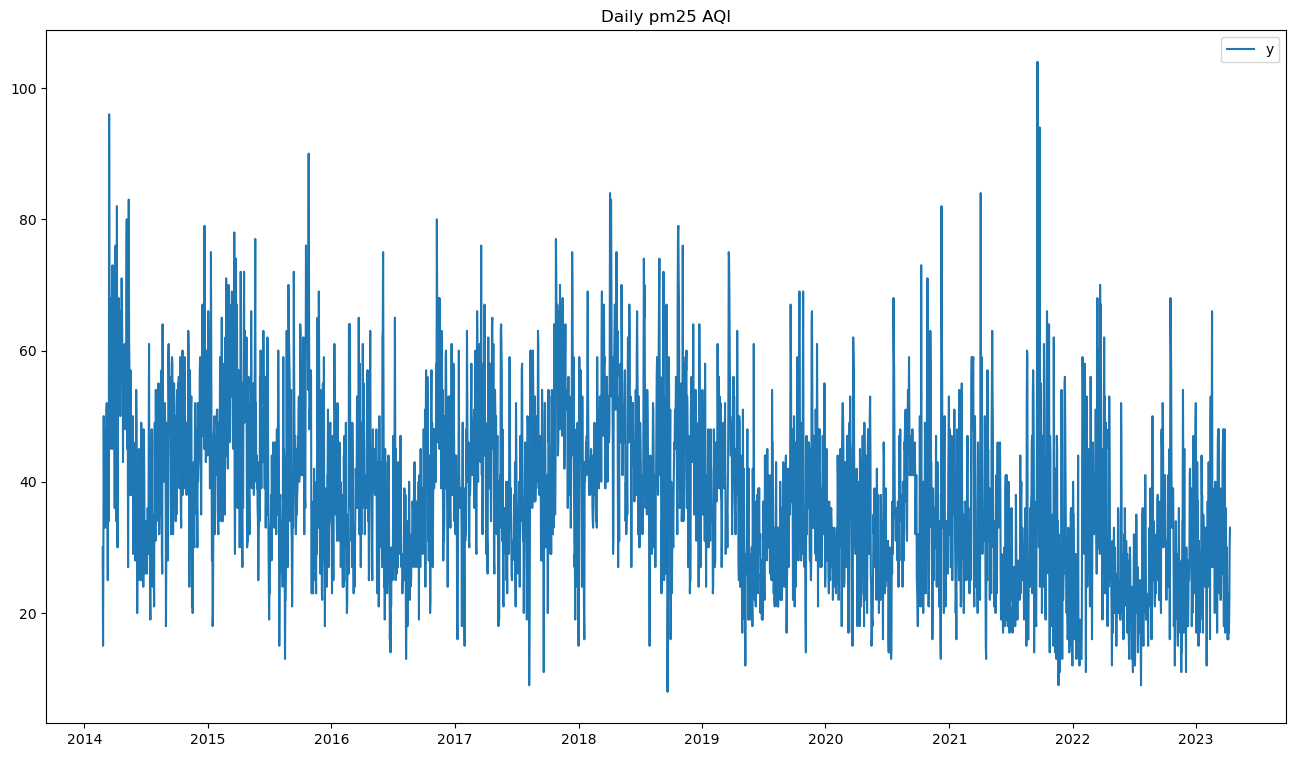

In [35]:
#line plot 
sns.lineplot(data=raw_df)
plt.title("Daily pm25 AQI")
plt.rcParams["figure.figsize"] = (16,9)
plt.show()

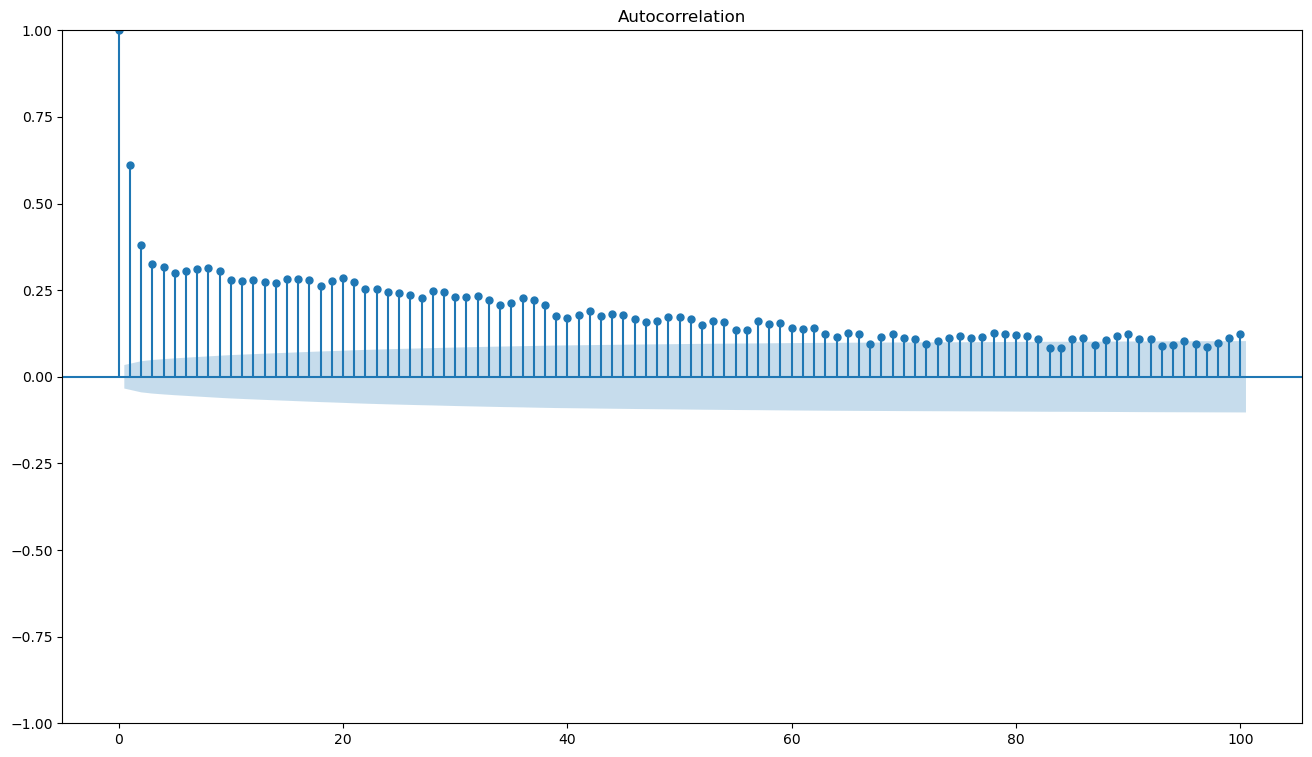

In [36]:
# ACF plot
fig1 = plot_acf(raw_df['y'], lags=100)
plt.rcParams["figure.figsize"] = (16,9)
plt.show()

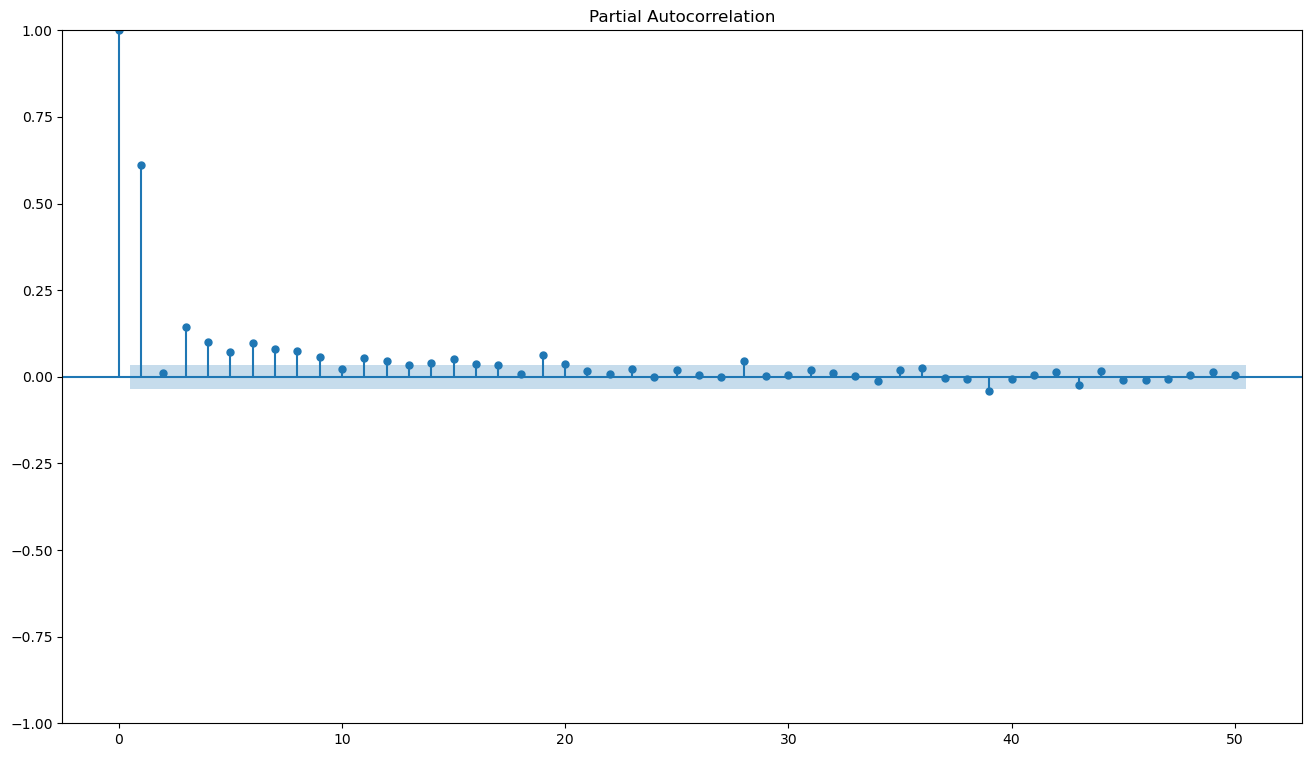

In [37]:
fig1 = plot_pacf(raw_df['y'], lags=50,method="yw")
plt.rcParams["figure.figsize"] = (16,9)
plt.show()

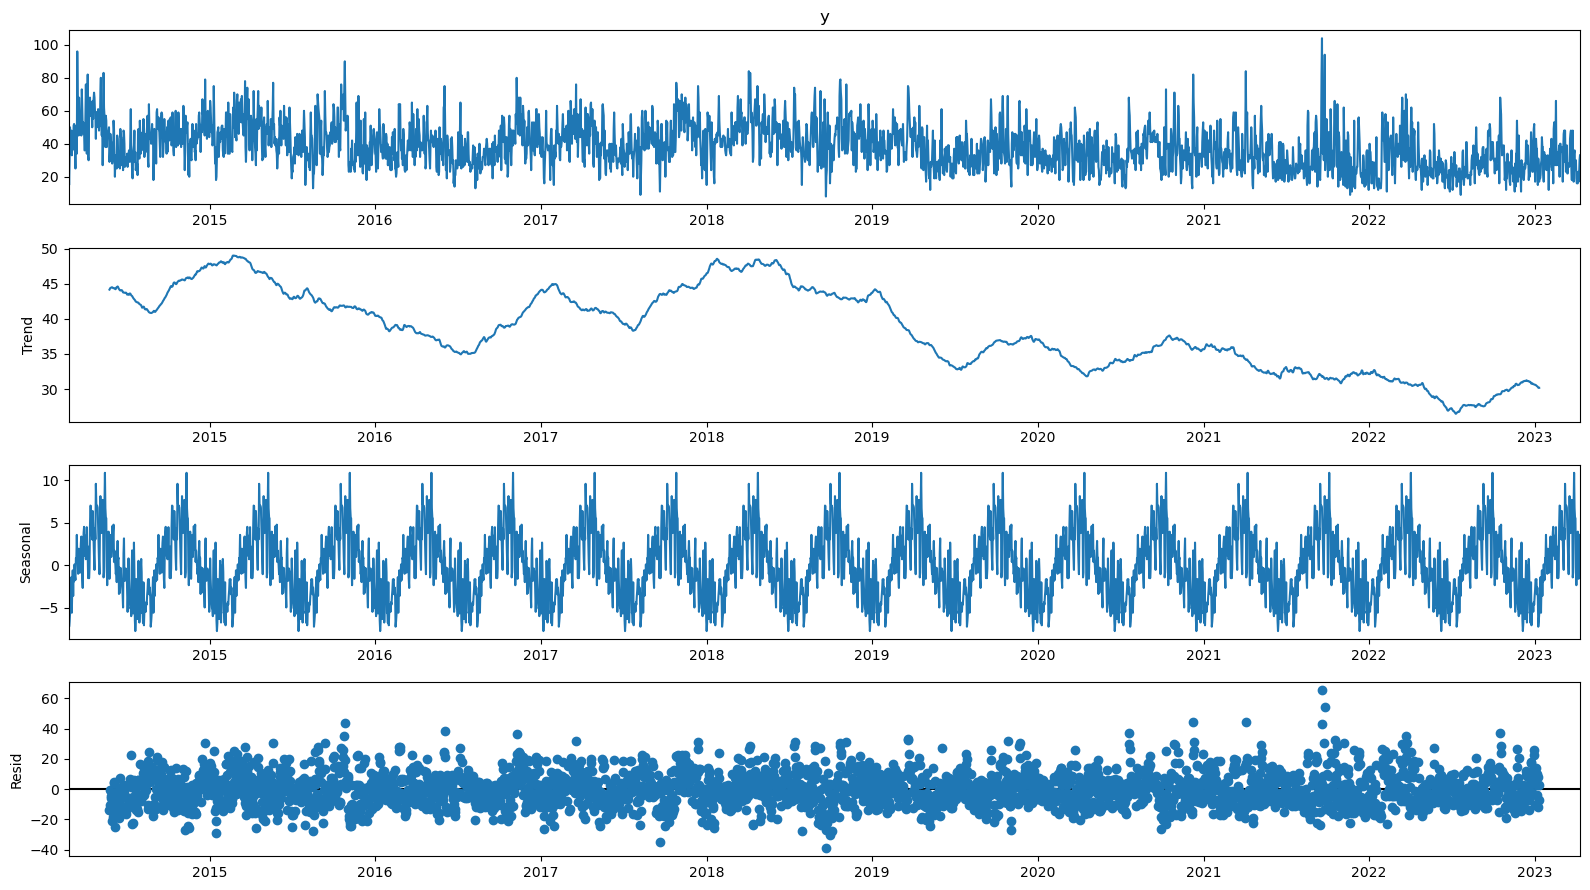

In [38]:
# seasonal decompostion 
decomp_viz = seasonal_decompose(raw_df["y"],model="additive", period=180)
fig = decomp_viz.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()


### - Augmented Dickey-Fuller Test
- H0 (Null Hypothesis): there is a unit root
- HA (Alternative Hypothesis):there is no unit root. 
- **Results:** reject the null there is no unit root 

In [39]:
adfuller(raw_df["y"], maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-5.80842680536485,
 4.459742985697203e-07,
 19,
 3314,
 {'1%': -3.4323247653622984,
  '5%': -2.862412535080238,
  '10%': -2.5672344682004145},
 24623.961888016944)

### - KPSS unit root test 
- H0 (Null Hypothesis): the time series is stationary 
- HA (Alternative Hypothesis): the time series is non-stationary
- **Results:** reject the null hypothesis the data is non stationary 

In [40]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
kpss_test(raw_df["y"])

Results of KPSS Test:
Test Statistic            4.271559
p-value                   0.010000
Lags Used                31.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


### - Breusch-Pagan Test of Heteroscedasticity 

 - H0 (Null Hypothesis): Homoscedasticity is present (the residuals are distributed with equal variance)
 - HA (Alternative Hypothesis): Heteroscedasticity is present (the residuals are not distributed with equal variance)
- **Results:** Reject the null hypothesis Heteroscedasticity is present

In [41]:
from statsmodels.formula.api import ols
f =" y~ds"
df_model = ols(formula=f, data=raw_df).fit() 

In [42]:
def test_model(col):
    s = []
    for i in col:
        a = [1,i]
        s.append(a)
    return (np.array(s))

pm_model = test_model(raw_df['y'])


In [43]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(df_model.resid, pm_model)
print ('LM-test p-value')
print (bp_test[1])


LM-test p-value
0.34449510545917106


# -Models  



Note on the Package used for modeling 
>The models used in this project come from the <a href="https://nixtla.github.io/statsforecast/">statsforecast</a> package. The statsforcast package is used for the modeling because it is much faster than other python time series packages. The speed allows for many models to be trained via cross vaildation in a resonable amount of time.

The data has both a trend and seasonality present, this gives a clue as to what models should be used for the forcast. Baseline model selected is seasonal naive, with a season of 180 days. The second model is the Holt winters
Exponential smoothing, it has the season set to 180 and specifed as additive. The models where trained on the entire data set (3355 days). The accuracy was detirmed through cross-validation with root mean ssquared error. The forecast point estimates and confidence intervals are generated for 15 days. The holt winters model preformed slighly better than the niave model but has much larger uncertainty. The holt winters looks like it does not do a great job of capturing the fluctuations in the data. 

In [44]:


models = [
    HoltWinters(season_length=season_len),
    SeasonalNaive(season_length=season_len),
    #AutoTheta(season_length=season_len),
    #AutoARIMA(season_length=season_len),
]

In [45]:
sf = StatsForecast(
    df=raw_df, 
    models=models,
    freq='D', 
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=7)
)

In [46]:
forecasts_df = sf.forecast(h=15, level=[90])

In [47]:
forecasts_df.head()

,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,
pm25,2023-04-12,17.0,-27.172216,61.172218,45.0,17.228539,72.771461
pm25,2023-04-13,16.0,-28.172216,60.172218,16.0,-11.771461,43.771461
pm25,2023-04-14,23.0,-21.172216,67.172218,46.0,18.228539,73.771461
pm25,2023-04-15,17.0,-27.172216,61.172218,68.0,40.228539,95.771461
pm25,2023-04-16,21.0,-23.172216,65.172218,62.0,34.228539,89.771461


In [48]:
sf.plot(raw_df,forecasts_df)

In [49]:
crossvaldation_df = sf.cross_validation(
    df=raw_df,
    h=30,
    step_size=30,
    n_windows=5
  )

In [50]:
crossvaldation_df.head()


,ds,cutoff,y,HoltWinters,SeasonalNaive
unique_id,,,,,
pm25,2022-11-13,2022-11-12,26.0,22.0,20.0
pm25,2022-11-14,2022-11-12,25.0,17.0,22.0
pm25,2022-11-15,2022-11-12,17.0,15.0,25.0
pm25,2022-11-16,2022-11-12,22.0,24.0,20.0
pm25,2022-11-17,2022-11-12,20.0,29.0,19.0


In [51]:
# couldnt download this portion of the package so I found it on github and saved it as a python file that is callable
#https://github.com/Nixtla/datasetsforecast/blob/main/datasetsforecast/losses.py
from DatasetsForecast import *   

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [52]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, rmse)

evaluation_df.head()

,HoltWinters,SeasonalNaive,best_model
unique_id,,,
pm25,13.421636,13.694366,HoltWinters
